**Objective**

To build an intelligent, data-driven dynamic pricing engine for 14 urban parking lots using historical occupancy, queue length, traffic conditions, and special day indicators. The goal is to optimize pricing in real time and reduce both underutilization and overcrowding.

In [44]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset (1).csv


In [45]:
import pandas as pd
import numpy as np

# Load your original dataset
df = pd.read_csv('dataset(1).csv')


# Keep only 14 lots (or pick 14 random ones)
lot_ids = df['ID'].sample(14, random_state=42).tolist()
df = df[df['ID'].isin(lot_ids)].reset_index(drop=True)

# Define 73 days × 18 time steps = 1314 timepoints
num_days = 73
timepoints_per_day = 18
total_steps = num_days * timepoints_per_day

# Generate all timestamps
timestamps = pd.date_range(start='2025-05-01 08:00:00', periods=total_steps, freq='30min')

# Now repeat each lot 1314 times
df_expanded = pd.DataFrame()
for lot_id in lot_ids:
    lot_row = df[df['ID'] == lot_id].iloc[0]
    for ts in timestamps:
        modified_row = lot_row.copy()

        # Modify the values to simulate changing conditions
        modified_row['timestamp'] = ts
        modified_row['occupancy'] = np.random.randint(0, lot_row['Capacity'])
        modified_row['queue_length'] = np.random.randint(0, 5)
        modified_row['traffic'] = np.random.choice(['low', 'average', 'high'])
        modified_row['vehicle_type'] = np.random.choice(['car', 'bike', 'truck'])
        modified_row['is_special_day'] = np.random.choice([0, 1], p=[0.9, 0.1])  # Mostly normal days

        df_expanded = pd.concat([df_expanded, pd.DataFrame([modified_row])], ignore_index=True)

# Rearranging timestamp and sorting
df_expanded['timestamp'] = pd.to_datetime(df_expanded['timestamp'])
df_expanded = df_expanded.sort_values(by=['ID', 'timestamp']).reset_index(drop=True)


In [46]:
import pandas as pd
import numpy as np

# Step 1: Load and rename columns
df = pd.read_csv('dataset.csv')

# Rename columns for easy access
df.columns = ['row_id', 'lot_code', 'capacity', 'lat', 'lon', 'occupancy',
              'vehicle_type', 'traffic', 'queue_length', 'is_special_day',
              'date', 'time']

# Step 2: Create timestamp
df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d-%m-%Y %H:%M:%S')

# Step 3: Sort by lot and time
df = df.sort_values(by=['lot_code', 'timestamp'])

# Step 4: Create occupancy ratio
df['occupancy_ratio'] = df['occupancy'] / df['capacity']

# Step 5: Map vehicle type weights
vehicle_weights = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
df['vehicle_weight'] = df['vehicle_type'].map(vehicle_weights)

# Step 6: Map traffic levels to numeric
traffic_mapping = {'low': 1, 'average': 2, 'high': 3}
df['traffic_numeric'] = df['traffic'].map(traffic_mapping)

# Ensure is_special_day is integer
df['is_special_day'] = df['is_special_day'].astype(int)


In [47]:
import pandas as pd
df=pd.read_csv('dataset.csv')
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [48]:
import numpy as np
import matplotlib.pyplot as plt


In [50]:
df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d-%m-%Y %H:%M:%S')

df = df.sort_values(by=['id', 'timestamp'])  # important for time series logic

In [43]:
df['occupancy_ratio'] = df['occupancy'] / df['capacity']

vehicle_weights = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
df['vehicle_weight'] = df['vehicle_type'].map(vehicle_weights)

df['is_special_day'] = df['is_special_day'].astype(int)

In [56]:
# Calculate occupancy ratio, vehicle weight, and ensure is_special_day is integer
df['occupancy_ratio'] = df['occupancy'] / df['capacity']

vehicle_weights = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
df['vehicle_weight'] = df['vehicle_type'].map(vehicle_weights)

df['is_special_day'] = df['is_special_day'].astype(int)

**Model 1: Baseline Linear Pricing**

Formula:
price t
+
1
=

**price**
𝑡
+
𝛼
⋅
(
Occupancy
Capacity
)
Price
t+1
​
 =Price
t
​
 +α⋅(
Capacity
Occupancy
​
 )
Starts from a base price of $10.

Increases price linearly as occupancy rises.

Simple, acts as a reference model.

In [61]:
def baseline_price(df, alpha=5):
    df['price_model1'] = 10.0  # base price
    for lot in df['code'].unique():
        lot_df = df[df['code'] == lot]
        for i in range(1, len(lot_df)):
            prev_idx = lot_df.index[i - 1]
            curr_idx = lot_df.index[i]
            prev_price = df.loc[prev_idx, 'price_model1']
            occ_ratio = df.loc[curr_idx, 'occupancy_ratio']
            new_price = prev_price + alpha * occ_ratio
            df.loc[curr_idx, 'price_model1'] = np.clip(new_price, 5, 20)
    return df

df = baseline_price(df)

In [57]:
df = baseline_price(df)

**Model 2: Demand-Based Dynamic Pricing**

**Formula:**

Demand
=
𝛼
⋅
(
Occupancy
Capacity
)
+
𝛽
⋅
Queue Length
−
𝛾
⋅
Traffic
+
𝛿
⋅
IsSpecialDay
+
𝜖
⋅
VehicleType Weight
Demand=α⋅(
Capacity
Occupancy
​
 )+β⋅Queue Length−γ⋅Traffic+δ⋅IsSpecialDay+ϵ⋅VehicleType Weight
Price
𝑡
=
10
⋅
(
1
+
𝜆
⋅
Normalized Demand
)
Price
t
​
 =10⋅(1+λ⋅Normalized Demand)
Takes into account:

Occupancy rate

Queue length

Traffic condition

Special day indicator

Vehicle type (car, bike, truck)

In [58]:
# Map traffic conditions to numerical values
traffic_mapping = {'low': 1, 'average': 2, 'high': 3}
df['traffic_numeric'] = df['traffic'].map(traffic_mapping)

# Define weights
weights = {
    'occ': 0.4,
    'queue': 0.3,
    'traffic': 0.2,
    'special': 0.1,
    'vehicle': 0.2
}

# Define demand function
def demand_function(row, w):
    return (
        w['occ'] * row['occupancy_ratio'] +
        w['queue'] * row['queue_length'] -
        w['traffic'] * row['traffic_numeric'] +
        w['special'] * row['is_special_day'] +
        w['vehicle'] * row['vehicle_weight']
    )

df['demand_raw'] = df.apply(lambda row: demand_function(row, weights), axis=1)

# Normalize demand
min_d = df['demand_raw'].min()
max_d = df['demand_raw'].max()
df['demand_norm'] = (df['demand_raw'] - min_d) / (max_d - min_d)

# Compute price_model2
λ = 0.5
df['price_model2'] = 10 * (1 + λ * df['demand_norm'])
df['price_model2'] = df['price_model2'].clip(lower=5, upper=20)

In [59]:
# Calculate occupancy std for each lot
lot_std = df.groupby('code')['occupancy'].std()

# Pick the lot with highest variation
best_lot = lot_std.idxmax()
print(f"Best Lot Selected: {best_lot}")

sample_lot = df[df['code'] == best_lot].copy()

Best Lot Selected: Others-CCCPS135a


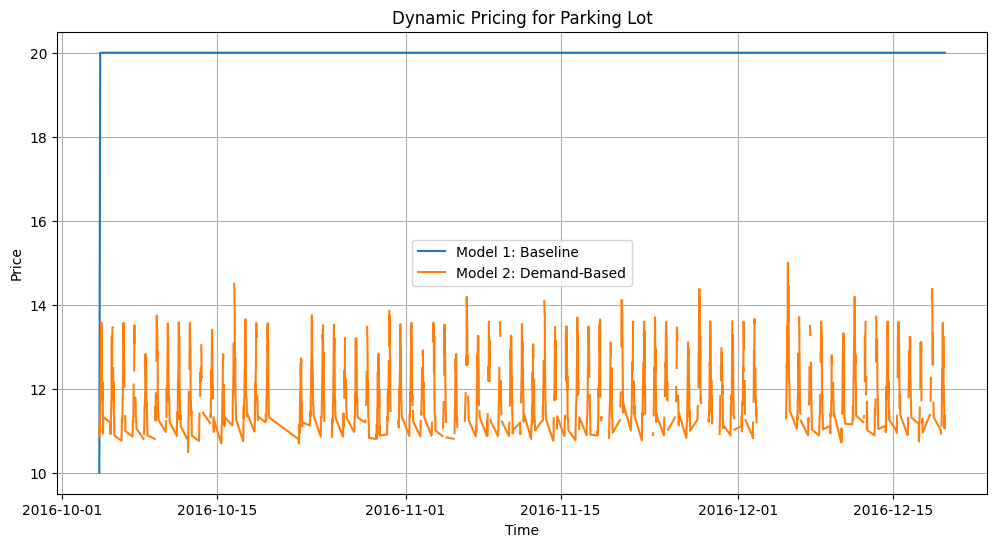

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(sample_lot['timestamp'], sample_lot['price_model1'], label='Model 1: Baseline')
plt.plot(sample_lot['timestamp'], sample_lot['price_model2'], label='Model 2: Demand-Based')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Dynamic Pricing for Parking Lot')
plt.legend()
plt.grid()
plt.show()

**Observations from Graph**

Model 1 quickly reaches the maximum price cap and stays constant.

Model 2 shows dynamic pricing based on real demand — smooth and realistic.

